In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import json

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, losses, metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Download train, validation and test dataframes

In [3]:
train_df = pd.read_csv("train.csv")
train_df.head()

,File,Encoded_Label
0,tiny-imagenet-200/train/n02437312/images/n0243...,53
1,tiny-imagenet-200/train/n02437312/images/n0243...,53
2,tiny-imagenet-200/train/n02437312/images/n0243...,53
3,tiny-imagenet-200/train/n02437312/images/n0243...,53
4,tiny-imagenet-200/train/n02437312/images/n0243...,53


In [4]:
val_df = pd.read_csv("val.csv")
val_df.head()

,File,Encoded_Label
0,val_4526.JPEG,115
1,val_7545.JPEG,88
2,val_1726.JPEG,149
3,val_4997.JPEG,99
4,val_6429.JPEG,149


In [5]:
test_df = pd.read_csv("test.csv")
test_df.head()

,File
0,val_9240.JPEG
1,val_9308.JPEG
2,val_3262.JPEG
3,val_3528.JPEG
4,val_4147.JPEG


## Data generators with keras

In [6]:
datagen = ImageDataGenerator(rescale=1./255)  # Adjust parameters as needed

In [7]:
# Create training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='File',
    y_col='Encoded_Label',
    target_size=(71, 71),  # Resize images
    batch_size=32,
    subset='training',  # Use for training subset
    class_mode = "raw",
    shuffle=True
)

Found 100000 validated image filenames.


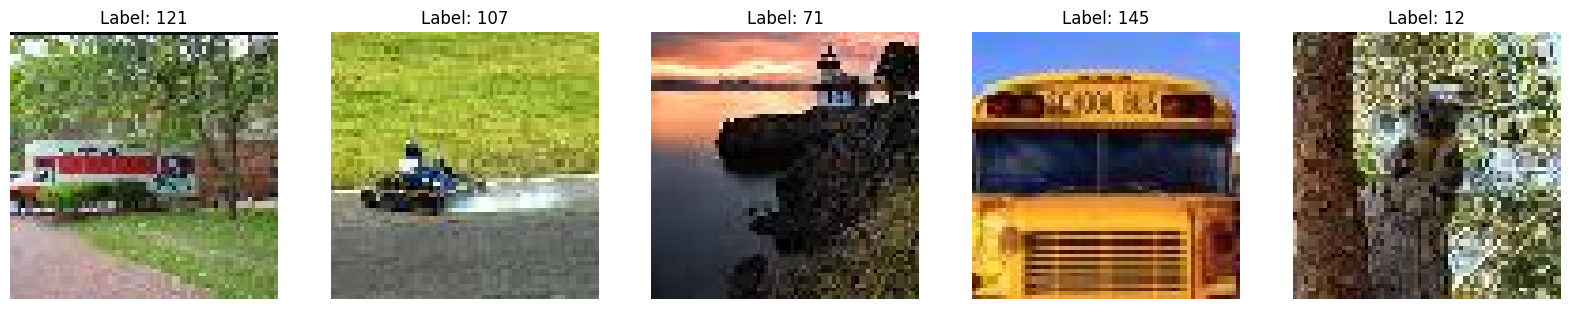

In [8]:
# Fetch a batch of images from the test generator
images = next(train_generator)


# Plotting the first few images in the batch
num_images_to_show = 5  # Number of images to display

plt.figure(figsize=(20, 10))
for i in range(num_images_to_show):
    ax = plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(images[0][i])
    plt.axis("off")
    
    # If predictions are available, display them
    plt.title(f"Label: {int(images[1][i])}")

plt.show()

In [9]:
# Path to the validation images
val_path = 'tiny-imagenet-200/val/images/'

# Create an ImageDataGenerator for validation without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling, no augmentation

# Create validation data generator
val_generator = val_datagen.flow_from_dataframe(
    directory = val_path,
    dataframe=val_df,
    x_col='File',
    y_col='Encoded_Label',
    target_size=(71, 71),  # Resize images to match model input
    batch_size=32,
    class_mode='raw',  # 'raw' for numerical labels, 'categorical' for one-hot encoded labels
    shuffle=False  # Typically, you don't shuffle validation data
)

Found 6000 validated image filenames.


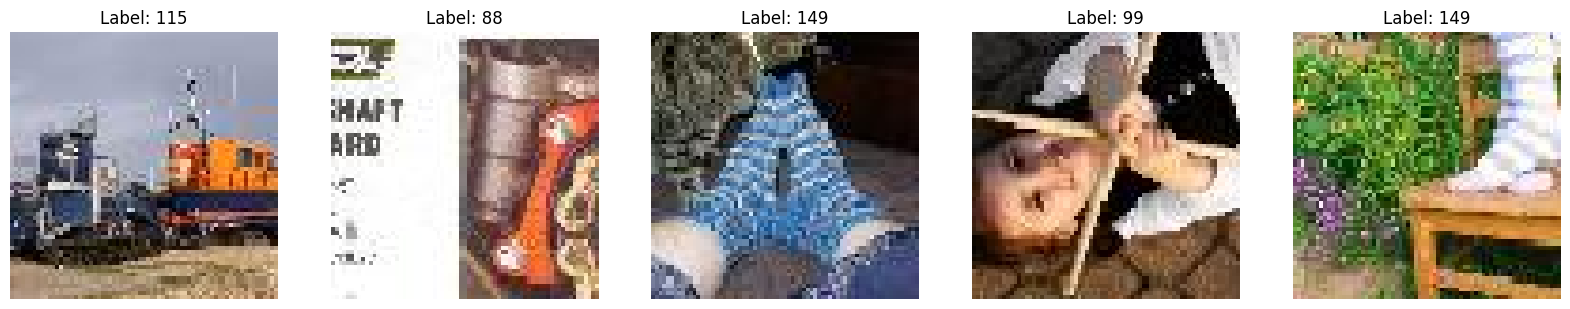

In [10]:
# Fetch a batch of images from the test generator
images = next(val_generator)

# Plotting the first few images in the batch
num_images_to_show = 5  # Number of images to display

plt.figure(figsize=(20, 10))
for i in range(num_images_to_show):
    ax = plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(images[0][i])
    plt.axis("off")
    
    # If predictions are available, display them
    plt.title(f"Label: {int(images[1][i])}")

plt.show()

In [11]:
# Create validation data generator
test_generator = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory = val_path,
    x_col='File',
    y_col=None,  # No labels for the test set
    class_mode=None,
    target_size=(71, 71),  # Resize images to match model input
    batch_size=32,
    shuffle=False  # Typically, you don't shuffle validation data
)

Found 4000 validated image filenames.


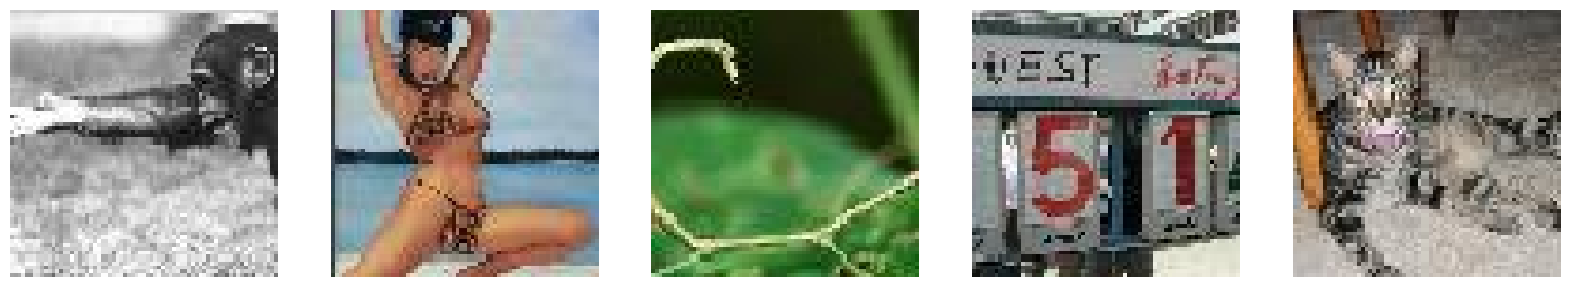

In [12]:
# Fetch a batch of images from the test generator
images = next(test_generator)

# Plotting the first few images in the batch
num_images_to_show = 5  # Number of images to display

plt.figure(figsize=(20, 10))
for i in range(num_images_to_show):
    ax = plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(images[i])
    plt.axis("off")
    

plt.show()

In [13]:
# Hiperparámetros básicos (ajústalos si lo necesitas)
IMG_SIZE = 71           # Tiny ImageNet original = 64
BATCH_SIZE = 128
EPOCHS_STAGE1 = 60
EPOCHS_STAGE2 = 30      # Ajuste fino
LEARNING_RATE_1 = 1e-3
LEARNING_RATE_2 = 3e-4  # LR más bajo para el ajuste fino
LABEL_SMOOTHING = 0.05  # Suavizado de etiquetas (ayuda vs. overfitting)
NUM_CLASSES = 200       # Tiny ImageNet

# Dónde guardar el mejor modelo y resultados
OUTPUT_DIR = "./outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
BEST_MODEL_PATH = os.path.join(OUTPUT_DIR, "best_model.keras")
HISTORY_PATH    = os.path.join(OUTPUT_DIR, "history_stage1.json")
HISTORY2_PATH   = os.path.join(OUTPUT_DIR, "history_stage2.json")
SUBMISSION_PATH = os.path.join(OUTPUT_DIR, "submission.csv")


In [59]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def inverted_residual(x, filters, expansion=4, stride=1, se_ratio=0.25,
                      l2_weight=1e-4, name=None):
    """MobileNetV2-style block with optional squeeze & excitation."""
    shortcut = x
    in_channels = x.shape[-1]
    # Expansion
    expanded = layers.Conv2D(in_channels * expansion, 1, padding="same",
                             use_bias=False,
                             kernel_regularizer=regularizers.l2(l2_weight))(x)
    expanded = layers.BatchNormalization()(expanded)
    expanded = layers.ReLU(6.0)(expanded)

    # Depthwise conv
    dw = layers.DepthwiseConv2D(3, strides=stride, padding="same",
                                use_bias=False,
                                depthwise_regularizer=regularizers.l2(l2_weight))(expanded)
    dw = layers.BatchNormalization()(dw)
    dw = layers.ReLU(6.0)(dw)

    # Squeeze & Excitation
    if se_ratio:
        se = layers.GlobalAveragePooling2D()(dw)
        se = layers.Dense(int(in_channels * expansion * se_ratio), activation="relu")(se)
        se = layers.Dense(in_channels * expansion, activation="sigmoid")(se)
        dw = layers.Multiply()([dw, layers.Reshape((1,1,-1))(se)])

    # Projection
    projected = layers.Conv2D(filters, 1, padding="same", use_bias=False,
                              kernel_regularizer=regularizers.l2(l2_weight))(dw)
    projected = layers.BatchNormalization()(projected)

    # Residual if shape matches
    if stride == 1 and in_channels == filters:
        projected = layers.Add()([shortcut, projected])
    return projected


def build_robust_efficient_model(
    input_shape=(71, 71, 3),
    num_classes=200,
    l2_weight=1e-4,
    dropout_rate=0.3
):
    inp = layers.Input(shape=input_shape)

    # Stem
    x = layers.Conv2D(32, 3, strides=2, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(l2_weight))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.0)(x)

    # Stages of inverted residual blocks
    x = inverted_residual(x, 32, expansion=2, stride=1, l2_weight=l2_weight)
    x = inverted_residual(x, 64, expansion=4, stride=2, l2_weight=l2_weight)
    x = inverted_residual(x, 64, expansion=4, stride=1, l2_weight=l2_weight)
    x = inverted_residual(x, 96, expansion=6, stride=2, l2_weight=l2_weight)
    x = inverted_residual(x, 128, expansion=6, stride=1, l2_weight=l2_weight)

    # Head
    x = layers.Conv2D(256, 1, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(l2_weight))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(6.0)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inp, outputs=out, name="TinyImageNet_RobustEfficient")
    return model

# Example
model = build_robust_efficient_model()
model.summary()


Model: "TinyImageNet_RobustEfficient"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 71, 71, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 36, 36,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 36,    │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 36, 36,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 36, 36,    │      2,048 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 36,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 36, 36,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 36, 36,    │        576 │ re_lu_4[0][0]     │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 36,    │        256 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 36, 36,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ re_lu_5[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │      1,040 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      1,088 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 36, 36,    │          0 │ re_lu_5[0][0],    │
│                     │ 64)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 36, 36,    │      2,048 │ multiply[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 36,    │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 36, 36,    │          0 │ re_lu_3[0][0],  

 Total params: 635,656 (2.42 MB)

 Trainable params: 628,680 (2.40 MB)

 Non-trainable params: 6,976 (27.25 KB)

In [60]:
# ---- Callbacks y entrenamiento principal ----
cbs = [
    callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor="val_loss",
                              save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

opt = optimizers.Adam(learning_rate=LEARNING_RATE_1)
model.compile(
    optimizer=opt,
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[
        metrics.SparseCategoricalAccuracy(name="top1"),
        metrics.SparseTopKCategoricalAccuracy(k=5, name="top5")
    ],
)

# (Opcional) pesos de clase por desbalance
counts = train_df['Encoded_Label'].value_counts().sort_index().values
class_weight = {i: (len(train_df) / (NUM_CLASSES * c)) for i, c in enumerate(counts)}
# Puedes desactivar class_weight si se vuelve inestable:
# class_weight = None

steps_per_epoch = math.ceil(train_generator.n / BATCH_SIZE)
val_steps = math.ceil(val_generator.n / BATCH_SIZE)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps,
    epochs=EPOCHS_STAGE1,
    callbacks=cbs,
    class_weight=class_weight,
    verbose=1
)

# Guardar historial
with open(HISTORY_PATH, "w") as f:
    json.dump(history.history, f)

Epoch 1/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - loss: 5.2511 - top1: 0.0250 - top5: 0.0889
Epoch 1: val_loss improved from None to 4.74669, saving model to ./outputs/best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 512s 643ms/step - loss: 5.0045 - top1: 0.0376 - top5: 0.1332 - val_loss: 4.7467 - val_top1: 0.0632 - val_top5: 0.1988 - learning_rate: 0.0010
Epoch 2/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - loss: 4.5337 - top1: 0.0716 - top5: 0.2309
Epoch 2: val_loss improved from 4.74669 to 4.59063, saving model to ./outputs/best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 496s 634ms/step - loss: 4.4584 - top1: 0.0803 - top5: 0.2494 - val_loss: 4.5906 - val_top1: 0.0918 - val_top5: 0.2533 - learning_rate: 0.0010
Epoch 3/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - loss: 4.2237 - top1: 0.1124 - top5: 0.3111
Epoch 3: val_loss improved from 4.59063 to 4.30651, saving model to ./outputs/best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 495s 634ms/step - loss: 4.1703 - top1: 0.1172 - to

/Users/teoechavarria/Documents/GitHub/Machine-Learning-Models-Collection/Competicions/.venv/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_loss improved from 4.30651 to 3.98920, saving model to ./outputs/best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 493s 631ms/step - loss: 3.9874 - top1: 0.1415 - top5: 0.3719 - val_loss: 3.9892 - val_top1: 0.1416 - val_top5: 0.3743 - learning_rate: 0.0010
Epoch 5/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - loss: 3.8850 - top1: 0.1599 - top5: 0.3990
Epoch 5: val_loss improved from 3.98920 to 3.89786, saving model to ./outputs/best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 464s 594ms/step - loss: 3.8536 - top1: 0.1637 - top5: 0.4062 - val_loss: 3.8979 - val_top1: 0.1722 - val_top5: 0.3963 - learning_rate: 0.0010
Epoch 6/60
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - loss: 3.7638 - top1: 0.1807 - top5: 0.4272
Epoch 6: val_loss improved from 3.89786 to 3.77268, saving model to ./outputs/best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 390s 498ms/step - loss: 3.7348 - top1: 0.1846 - top5: 0.4331 - val_loss: 3.7727 - val_top1: 0.1835 - val_top5: 0.4335 - learning_rate: 0.0010
Epo

188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - loss: 2.5322 - top1: 0.4433 - top5: 0.7130
Validación - Loss, Top1, Top5: [2.532205581665039, 0.44333332777023315, 0.7129999995231628]


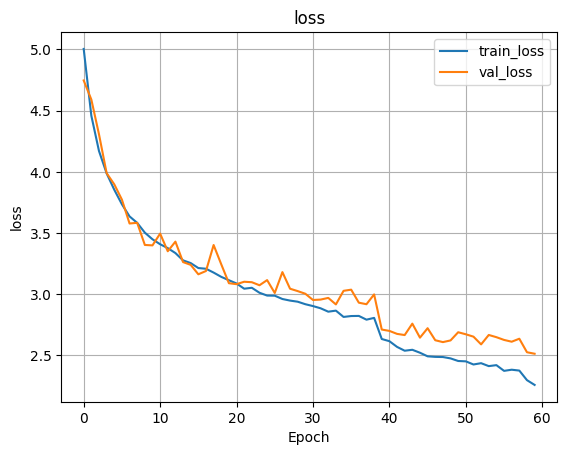

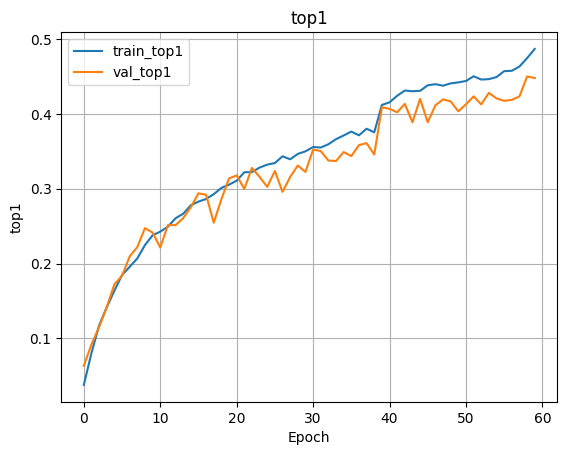

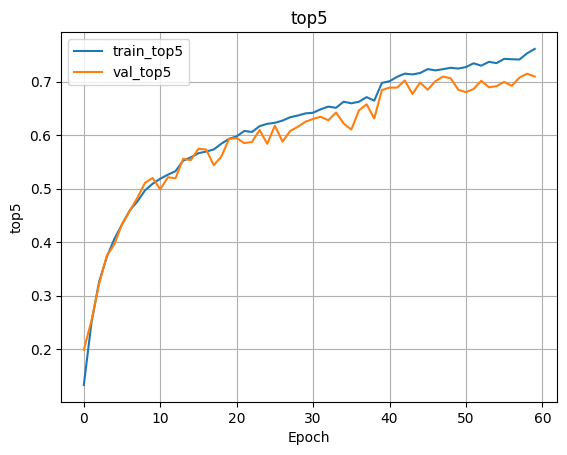

In [61]:
# ---- Métricas en validación y curvas ----
val_metrics = model.evaluate(val_generator, verbose=1)
print("Validación - Loss, Top1, Top5:", val_metrics)

import matplotlib.pyplot as plt

def plot_curves(hist, key='loss'):
    plt.figure()
    plt.plot(hist[key], label=f"train_{key}")
    plt.plot(hist[f"val_{key}"], label=f"val_{key}")
    plt.title(key)
    plt.xlabel("Epoch")
    plt.ylabel(key)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_curves(history.history, 'loss')
plot_curves(history.history, 'top1')
plot_curves(history.history, 'top5')

In [18]:
# ==============================================
# Kaggle: Keras filelist + PyTorch .pth → submission id,pred
# - Normalización ImageNet
# - target 224
# - corrige torch.load (weights_only=False)
# - evita multiprocessing pickle (num_workers=0)
# ==============================================
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

# ===== Config =====
PTH_PATH    = "/Users/teoechavarria/Documents/GitHub/Machine-Learning-Models-Collection/Competicions/model.pth"  # tu .pth
IMG_DIR     = val_path       # misma carpeta que usaste en flow_from_dataframe
OUTPUT_CSV  = "submission.csv"
NUM_CLASSES = 200            # Tiny ImageNet
IMG_SIZE    = 224
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Transforms (ImageNet) =====
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ===== Dataset usando el orden de Keras =====
class FromGeneratorFilelist(Dataset):
    def __init__(self, base_dir, filenames, transform=None):
        self.base_dir = base_dir
        self.filenames = list(filenames)   # orden ya está fijo (shuffle=False)
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        rel = self.filenames[idx]
        path = os.path.join(self.base_dir, rel)
        img = Image.open(path).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, os.path.basename(rel)  # id = nombre del archivo

# ===== Cargar ResNet-18 + pesos .pth (legacy) =====
def load_resnet18_from_pth(pth_path, num_classes, device):
    model = models.resnet18(weights=None)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)  # fc nueva para 200 clases

    # PyTorch 2.6: forzar weights_only=False, y cargar en CPU primero
    state_dict = torch.load(pth_path, map_location="cpu", weights_only=False)

    # Si el checkpoint es de ImageNet (1000 clases), elimina fc.*
    for k in list(state_dict.keys()):
        if k.startswith("fc."):
            state_dict.pop(k, None)

    model.load_state_dict(state_dict, strict=False)
    model.to(device)
    model.eval()
    return model

@torch.no_grad()
def infer_and_save(model, dataloader, device, out_csv):
    ids, preds = [], []
    for imgs, names in dataloader:
        imgs = imgs.to(device, non_blocking=False)
        logits = model(imgs)
        p = torch.argmax(logits, dim=1).cpu().tolist()
        ids.extend(names)
        preds.extend(p)
    pd.DataFrame({"id": ids, "pred": preds}).to_csv(out_csv, index=False)
    print("[OK] Guardado:", out_csv)

# ===== Ejecutar =====
ds = FromGeneratorFilelist(IMG_DIR, test_generator.filenames, transform=transform)
loader = DataLoader(ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)

model = load_resnet18_from_pth(PTH_PATH, NUM_CLASSES, DEVICE)
infer_and_save(model, loader, DEVICE, OUTPUT_CSV)




[OK] Guardado: submission.csv


In [62]:
import numpy as np

# Realizar las predicciones
pred_probs = model.predict(test_generator, verbose=1)

# Convertir a la clase más probable (entero de 0 a 199)
pred_labels = np.argmax(pred_probs, axis=1)


125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step


In [63]:
import pandas as pd

submission_df = pd.DataFrame({
    "id": test_df["File"],   # nombres de archivo tal cual aparecen en test_df
    "pred": pred_labels      # predicción numérica de la clase
})

# Guardar en el formato exacto requerido
submission_df.to_csv("submission.csv", index=False)

# Mostrar las primeras filas para verificar
print(submission_df.head())

              id  pred
0  val_9240.JPEG   156
1  val_9308.JPEG    74
2  val_3262.JPEG    40
3  val_3528.JPEG    86
4  val_4147.JPEG    30
